In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime
import importlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import create_and_plot as cp

`Load Dataframe`

In [2]:
df = pd.read_csv("FINAL_STOCKS.csv")
df.tail()

date  max_price  min_price  closing  opening  change_pctg volume  \
16530  2014-01-15       0.80       0.79     0.79     0.80         1.27  1,958   
16531  2014-01-14       0.79       0.79     0.80     0.79        -1.25    480   
16532  2014-01-12       0.80       0.80     0.82     0.80        -2.44    404   
16533  2014-01-08       0.82       0.82     0.81     0.82         1.23    200   
16534  2014-01-06       0.81       0.81     0.85     0.81        -4.71    136   

          value  n_deals   stock  
16530  2,188.15        5  Wassel  
16531    534.84        4  Wassel  
16532    455.85        3  Wassel  
16533    231.31        2  Wassel  
16534    155.37        1  Wassel

`Data summary`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16535 entries, 0 to 16534
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         16535 non-null  object 
 1   max_price    16535 non-null  float64
 2   min_price    16535 non-null  float64
 3   closing      16535 non-null  float64
 4   opening      16535 non-null  float64
 5   change_pctg  16535 non-null  float64
 6   volume       16535 non-null  object 
 7   value        16535 non-null  object 
 8   n_deals      16535 non-null  int64  
 9   stock        16535 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.3+ MB


In [4]:
df.isna().sum()

date           0
max_price      0
min_price      0
closing        0
opening        0
change_pctg    0
volume         0
value          0
n_deals        0
stock          0
dtype: int64

In [5]:
df.describe()

max_price     min_price       closing       opening   change_pctg  \
count  16535.000000  16535.000000  16535.000000  16535.000000  16535.000000   
mean       1.999178      1.980512      1.994600      1.994836      0.026739   
std        1.072794      1.066849      1.071422      1.071631      1.792375   
min        0.290000      0.290000      0.290000      0.290000    -47.640000   
25%        1.110000      1.100000      1.110000      1.110000     -0.540000   
50%        1.830000      1.810000      1.830000      1.830000      0.000000   
75%        2.530000      2.500000      2.520000      2.520000      0.520000   
max        7.000000      6.800000      6.840000      6.840000     31.940000   

            n_deals  
count  16535.000000  
mean       8.666526  
std       11.451771  
min        1.000000  
25%        2.000000  
50%        5.000000  
75%       11.000000  
max      173.000000

`Reorder columns`

In [6]:
df.rename(columns={'max_price':'highest', 'min_price':'lowest'}, inplace=True)
df.columns

Index(['date', 'highest', 'lowest', 'closing', 'opening', 'change_pctg',
       'volume', 'value', 'n_deals', 'stock'],
      dtype='object')

In [7]:
desired_order = ['stock', 'date'] + [ col for col in df.columns if col not in ['stock', 'date'] ]
desired_order

['stock',
 'date',
 'highest',
 'lowest',
 'closing',
 'opening',
 'change_pctg',
 'volume',
 'value',
 'n_deals']

In [8]:
df = df[desired_order]
df.tail()

stock        date  highest  lowest  closing  opening  change_pctg  \
16530  Wassel  2014-01-15     0.80    0.79     0.79     0.80         1.27   
16531  Wassel  2014-01-14     0.79    0.79     0.80     0.79        -1.25   
16532  Wassel  2014-01-12     0.80    0.80     0.82     0.80        -2.44   
16533  Wassel  2014-01-08     0.82    0.82     0.81     0.82         1.23   
16534  Wassel  2014-01-06     0.81    0.81     0.85     0.81        -4.71   

      volume     value  n_deals  
16530  1,958  2,188.15        5  
16531    480    534.84        4  
16532    404    455.85        3  
16533    200    231.31        2  
16534    136    155.37        1

# `1. EDA && Feature Engineering & Preprocessing`

## 1.1 `Standard EDA and Preprocessing`

`Datize the date column`

In [9]:
from preprocess import datize_date

In [10]:
df = datize_date(df)
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`See which stocks ahs the largest volume and #of trades`

In [11]:
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`Numerize the (value, volume) columns`

In [12]:
import preprocess
importlib.reload(preprocess)
from preprocess import numerize_value_and_volume

In [13]:
df = numerize_value_and_volume(df)
df[['value','volume']].dtypes

value     float64
volume    float64
dtype: object

In [14]:
df.groupby('stock')['volume'].sum().sort_values(ascending=False).head().to_frame()

volume
stock              
BoP     233303637.0
apic    217731363.0
Isbk    113171223.0
oreedo   70735761.0
AIB      43606684.0

In [15]:
df.groupby('stock')['n_deals'].sum().sort_values(ascending=False).head().to_frame()

n_deals
stock          
BoP       44264
apic      33722
oreedo    26076
Isbk      17927
AIB        6694

`Set stock, date as the index`

In [16]:
df.set_index('stock', inplace=True)
df.index.unique()

Index(['AIB', 'apic', 'BoP', 'bpc', 'GUI', 'Isbk', 'jph', 'oreedo', 'trust',
       'Wassel'],
      dtype='object', name='stock')

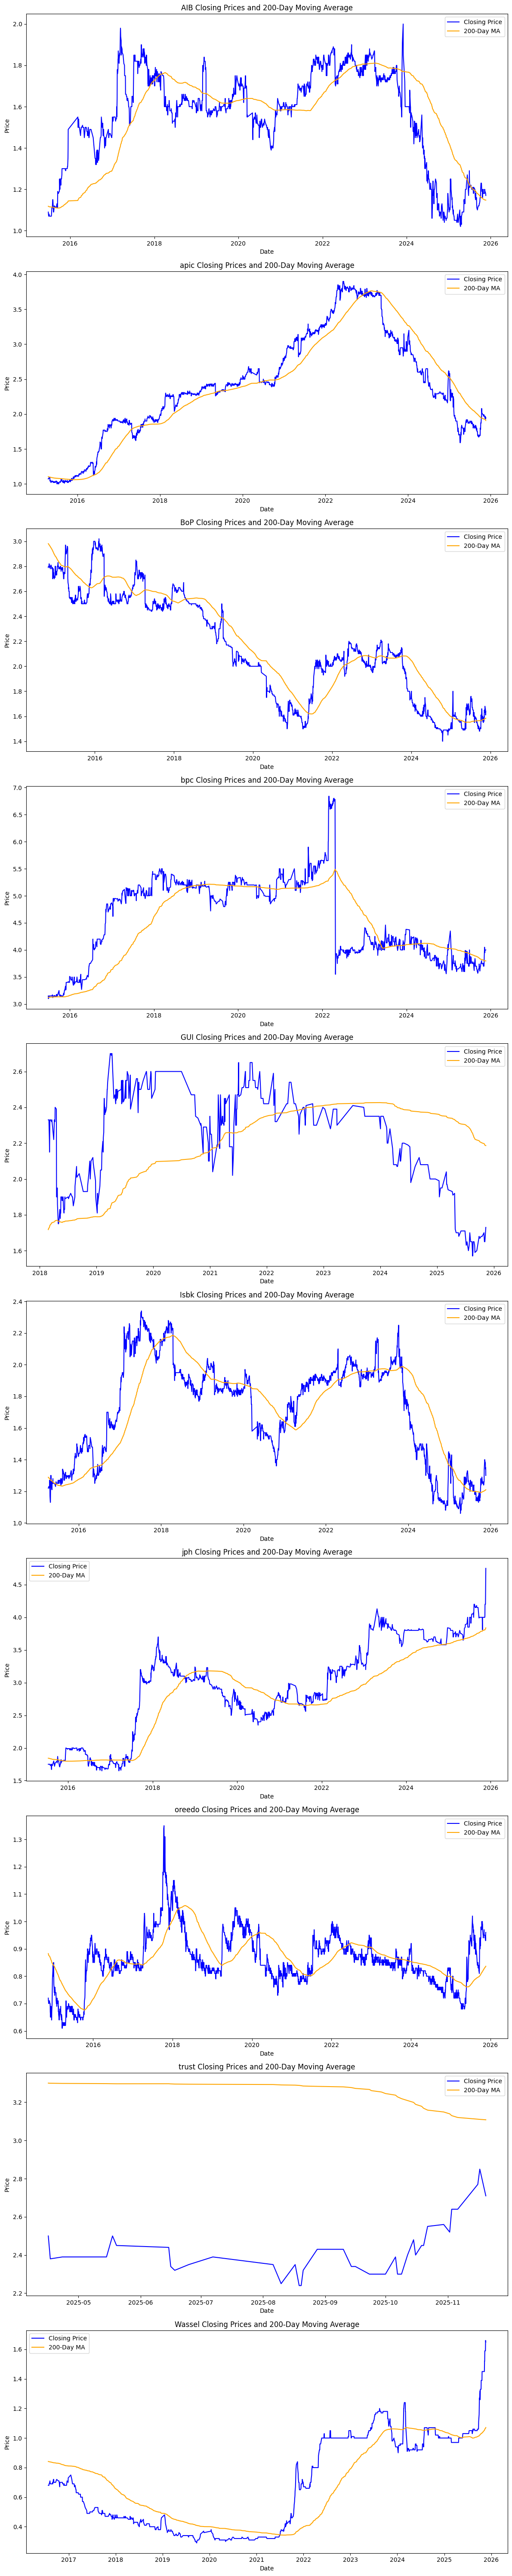

In [17]:
import visualize
importlib.reload(visualize)
from visualize import plot_stocks_closing_200MA
plot_stocks_closing_200MA(df)

`Working with individual stocks`

In [18]:
importlib.reload(utils)
from utils import take_stock

            highest  lowest  closing  opening  change_pctg   volume  \
date                                                                  
2014-01-02     3.20    3.19     3.20     3.19        -0.31  25566.0   
2014-01-05     3.17    3.12     3.19     3.13        -1.88  24331.0   
2014-01-06     3.15    3.12     3.13     3.13         0.00  94225.0   
2014-01-08     3.17    3.13     3.13     3.17         1.28  44673.0   
2014-01-09     3.19    3.17     3.17     3.19         0.63  29244.0   

                value  n_deals  
date                            
2014-01-02   81800.50       19  
2014-01-05   76502.03       28  
2014-01-06  295711.69       31  
2014-01-08  141304.63       19  
2014-01-09   93072.42       32  


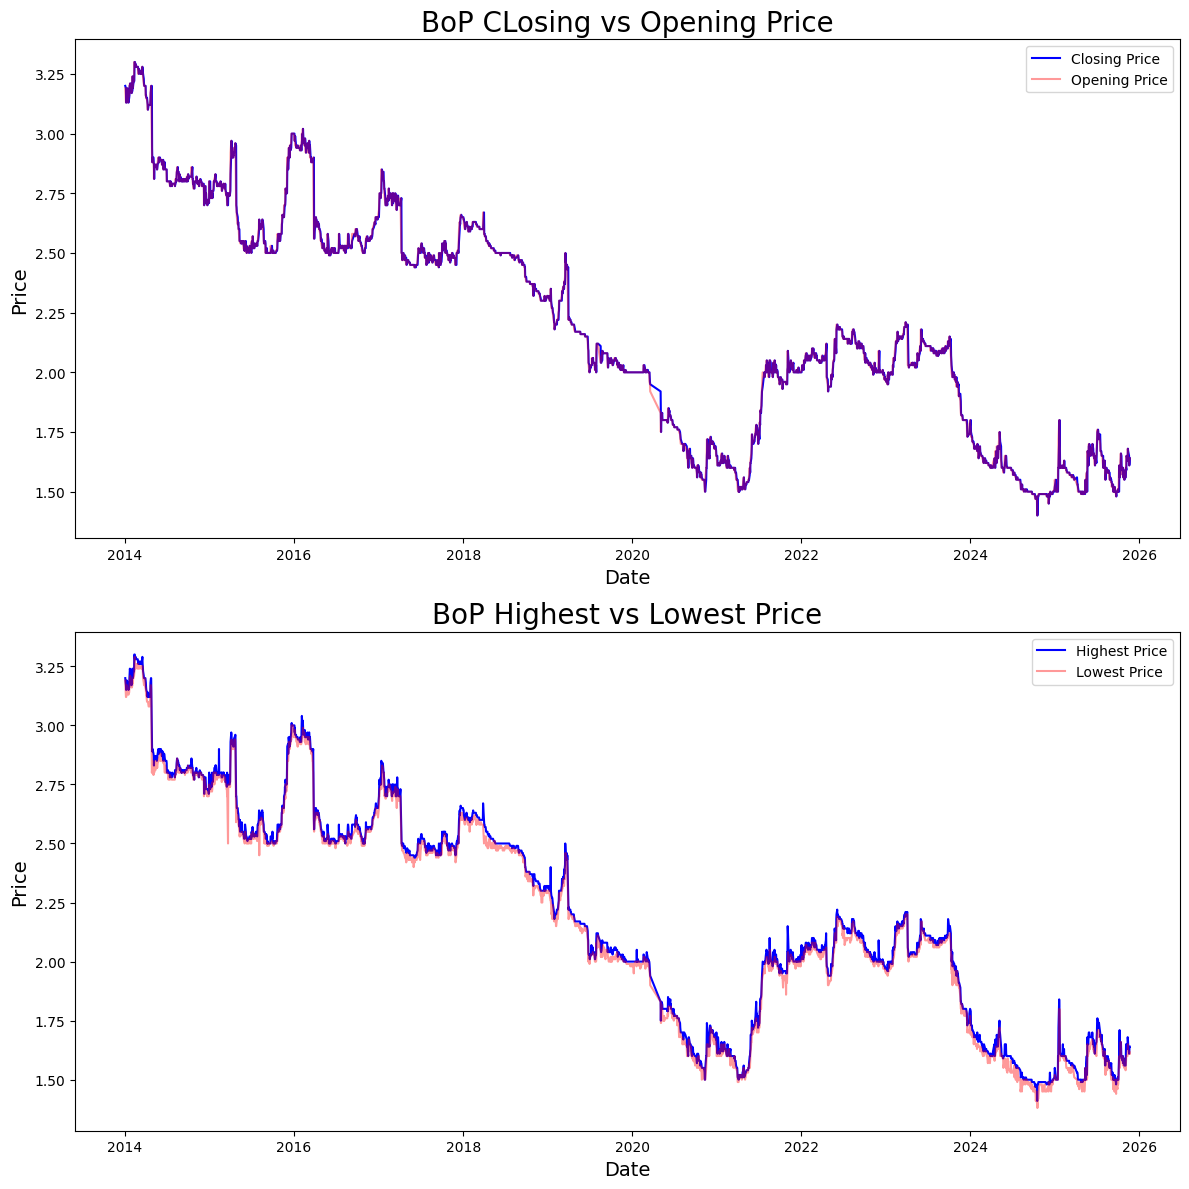

In [19]:
bop = take_stock(df, 'BoP')

`As we can see from the first graph we cacn tell that opening and closing prices are almost always identical indicating the low volatility in PEX in general`

----------------------------------

`The initial model we will try is to predict the direction of the movement for stock`

## 1.2 `Creating informative variables`

`First of all create the movemetn direction target variable`

`Create 1 Day Classification target variable with concern for predicting up movements`

### 1.2.1 `Create The Target Variable`

In [20]:
importlib.reload(utils)
from utils import create_and_plot as cp

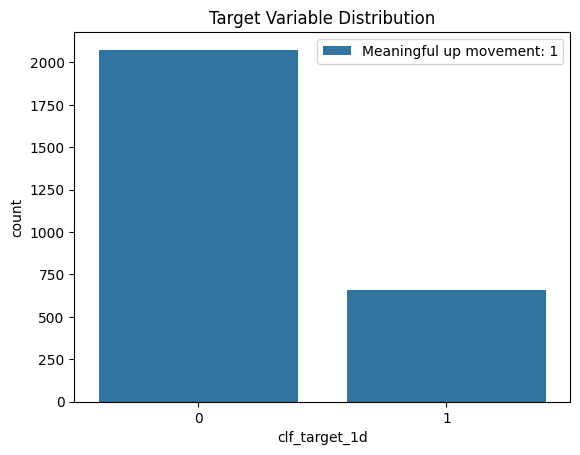

Variables with Strong Correlation with variable clf_target_1d (> 0.25) :  [('change_pctg', 0.592865615803275)]


In [21]:
bop = cp(bop, "target")

### 1.2.2 `Create Time Since Last Trade Variable`

In [22]:
importlib.reload(utils)
from utils import create_and_plot as cp

Maximum idle time between trades is: 45 days.


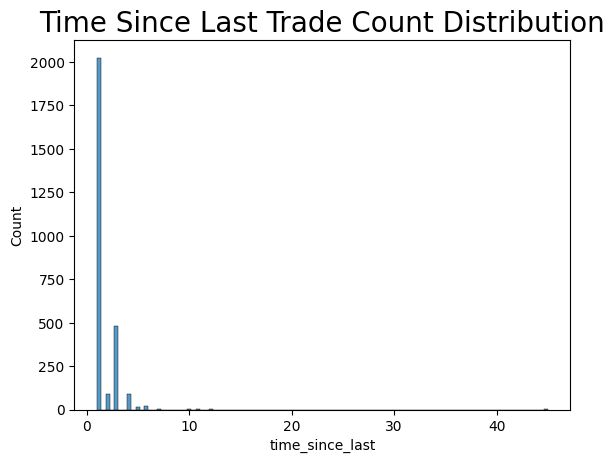

No Strong Pearson Correlations.


In [23]:
bop = cp(bop, "time_since_last")

### 1.2.3 `Create Moving Averages`

In [24]:
importlib.reload(utils)
from utils import create_and_plot as cp

Moving Average for 20 Days Created.
Moving Average for 50 Days Created.
Moving Average for 200 Days Created.
MA Ratio Created


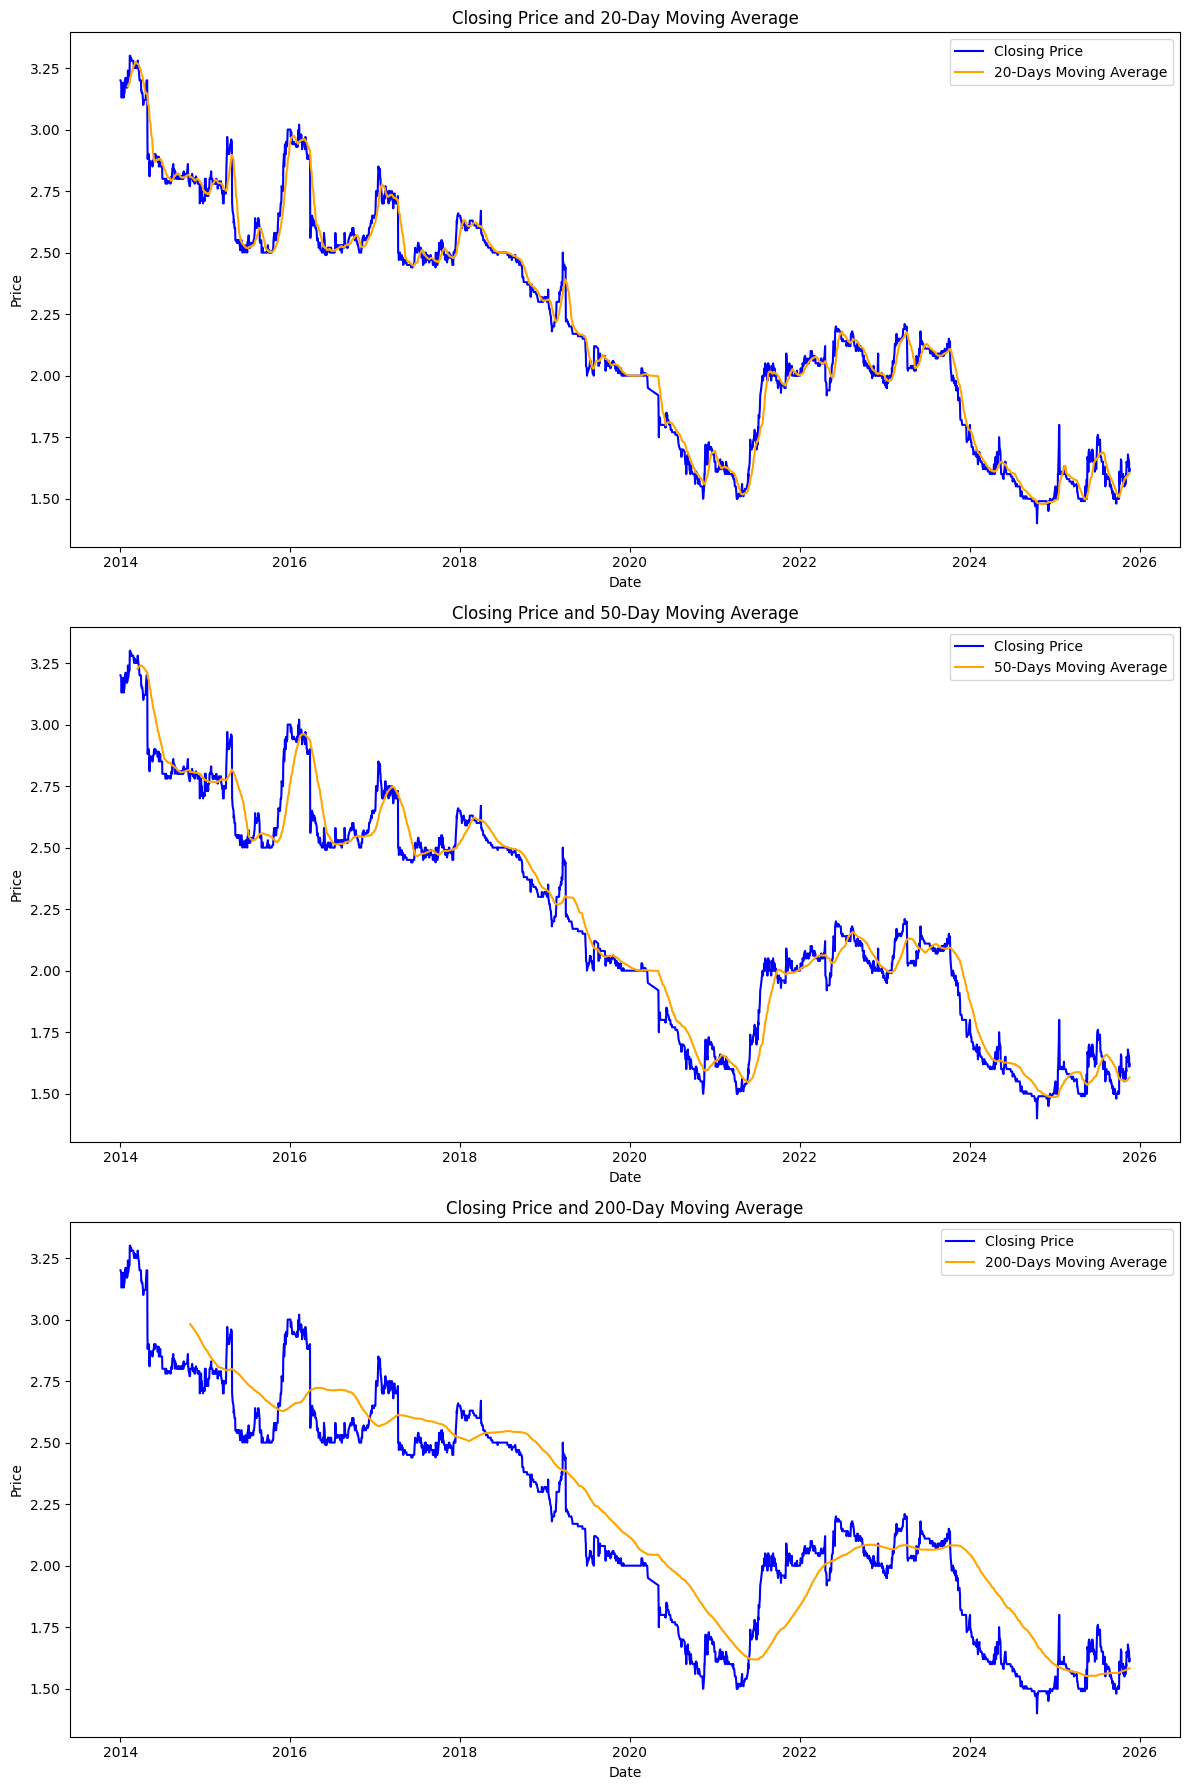

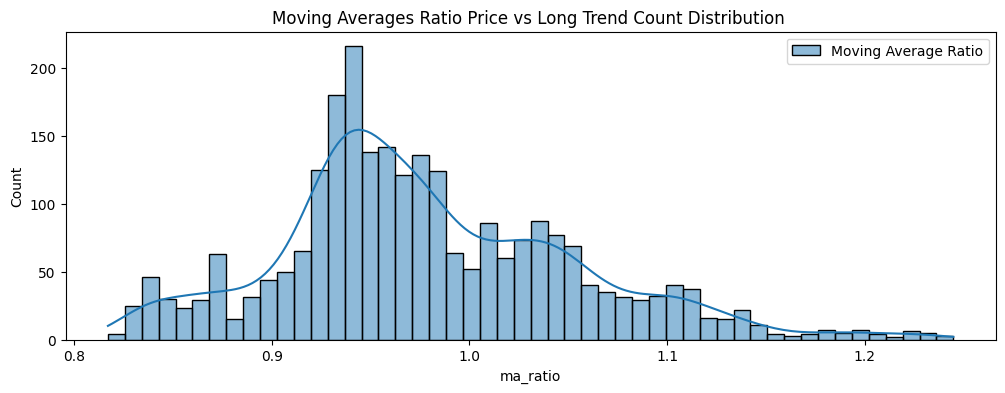

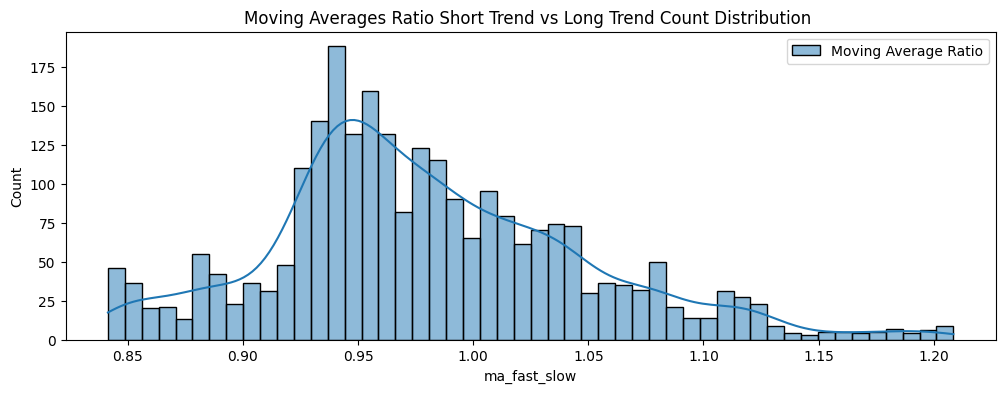

           20_MA     50_MA    200_MA
20_MA   1.000000  0.992926  0.941359
50_MA   0.992926  1.000000  0.958654
200_MA  0.941359  0.958654  1.000000
Variables with Strong Correlation with variable 20_MA (> 0.25) :  [('highest', 0.9919806150591076), ('lowest', 0.9919495385649161), ('closing', 0.9932790936145349), ('opening', 0.9921758857712485), ('n_deals', 0.2772051542715414), ('ma_fast_slow', 0.276939496177473)]


In [25]:
bop = cp(bop, "moving_averages")

`This chart makes total sense since PEX ahs very low volatility which is why even the 20MA almost perfectly hugs the closign price`

`MA won't reveal much information and alone is not enough for ML model to revela hideen patterns we need to create more features`

### 1.2.4 `Create Range Variable`

In [26]:
importlib.reload(utils)
from utils import create_and_plot as cp

Variables with Strong Correlation with variable range (> 0.25) :  [('n_deals', 0.3970993821851938)]


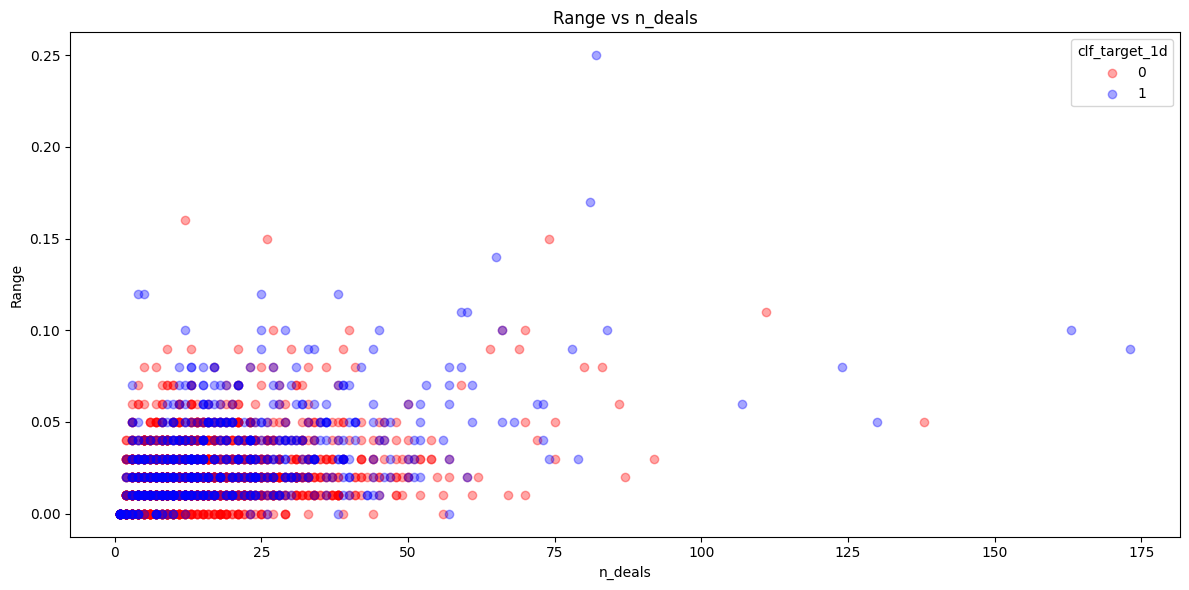

In [27]:
bop = cp(bop, "target", plot=False, corr=True)
bop = cp(bop, "range")

### 1.2.5 `Crate Daily Returns Variables`

1-Day Return Variable Created.
3-Day Return Variable Created.
5-Day Return Variable Created.


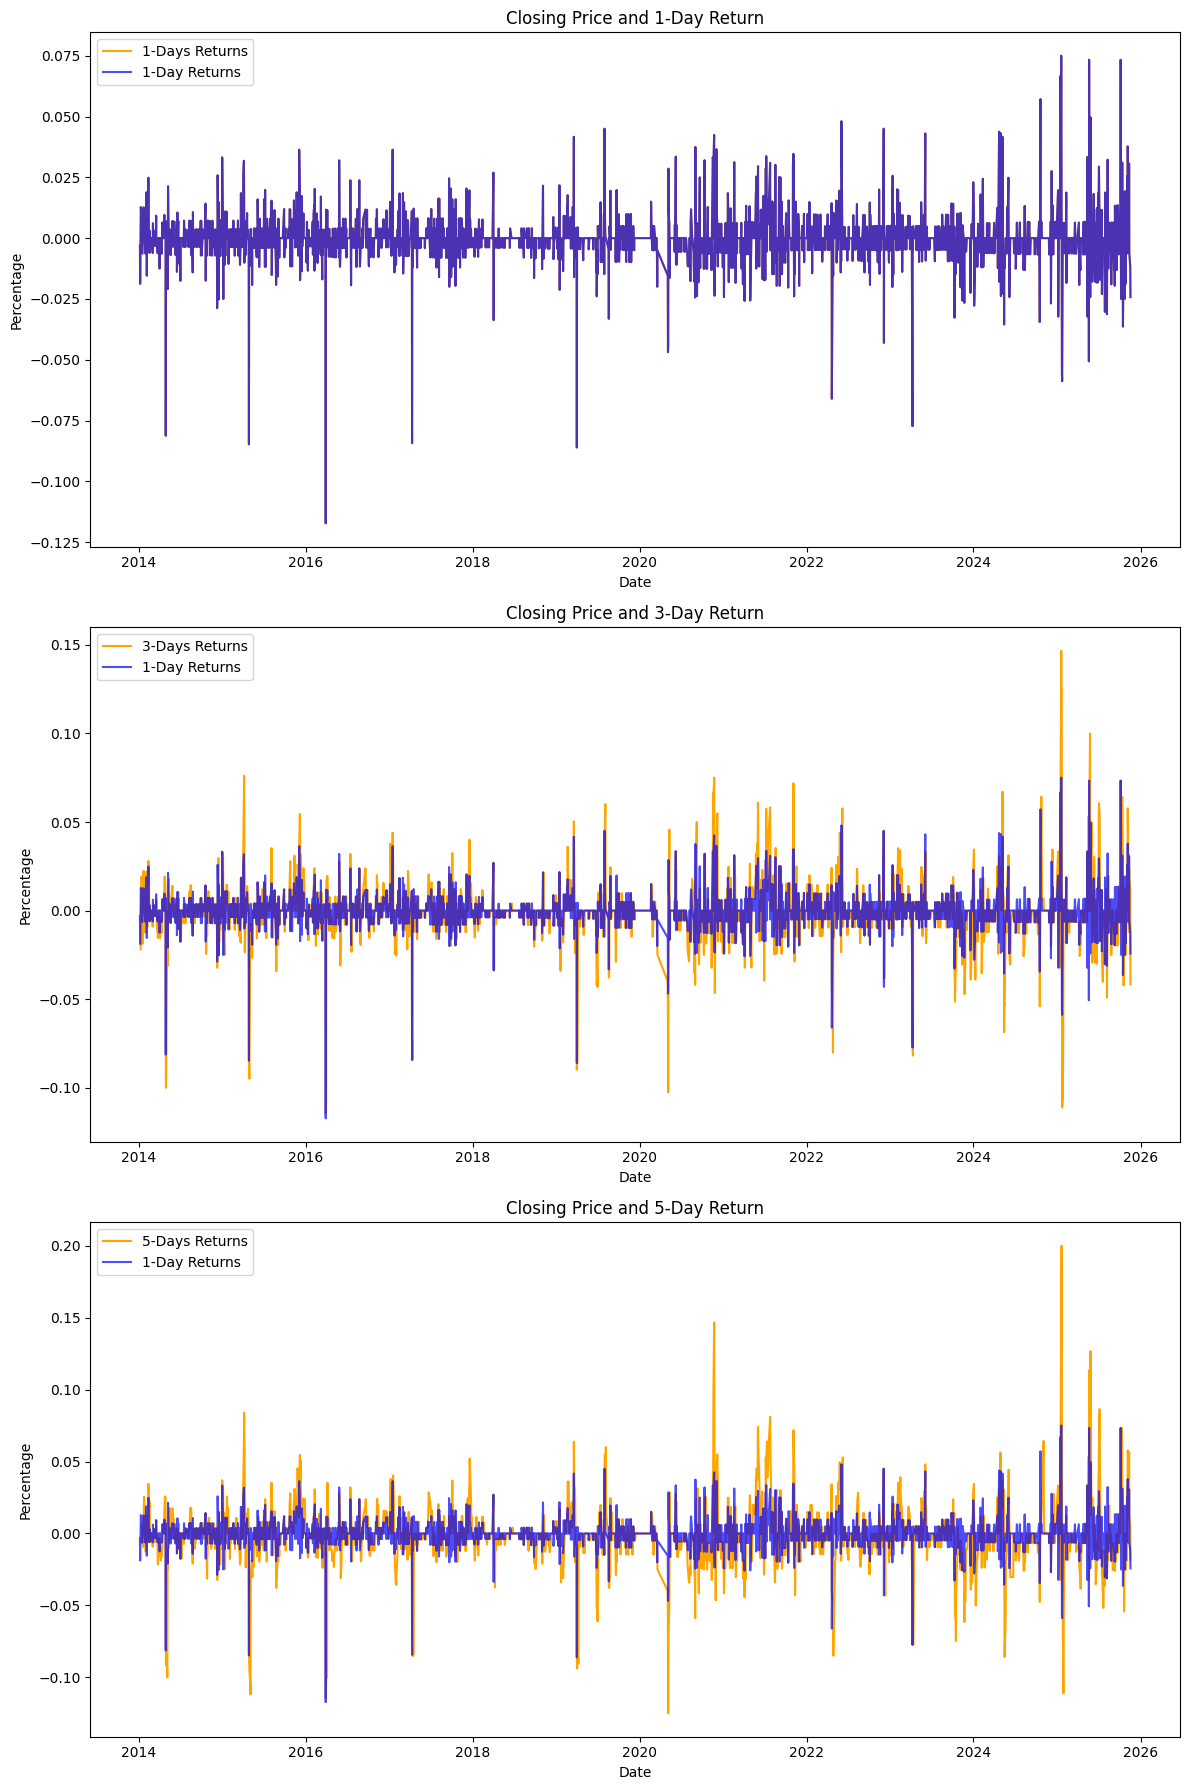

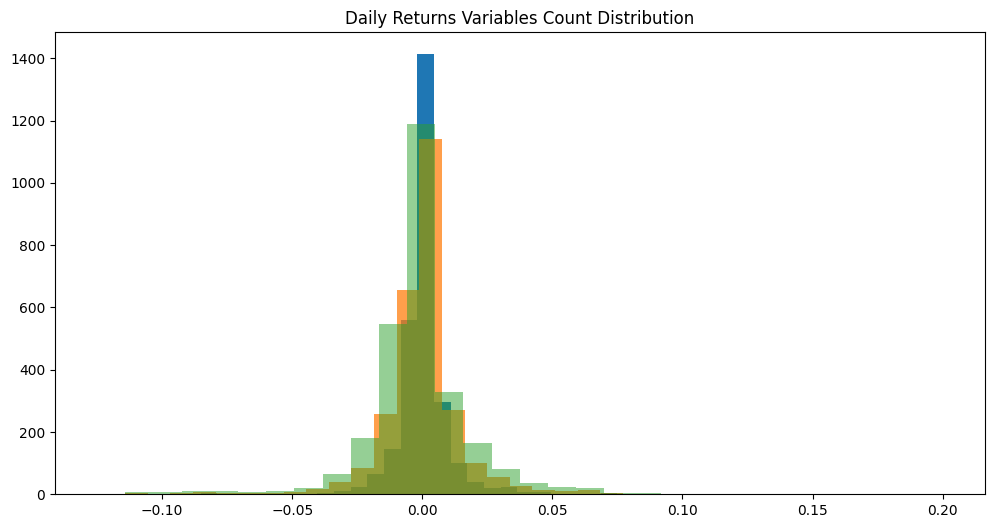

          r1        r3        r5
r1  1.000000  0.562517  0.443446
r3  0.562517  1.000000  0.761972
r5  0.443446  0.761972  1.000000
No Strong Pearson Correlations.


In [28]:
bop = cp(bop, "returns")

`As we can see the returns distibution has fatter tails on the longer run which makes total sense for a low volatility market`

### 1.2.6 `volatility X days`

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


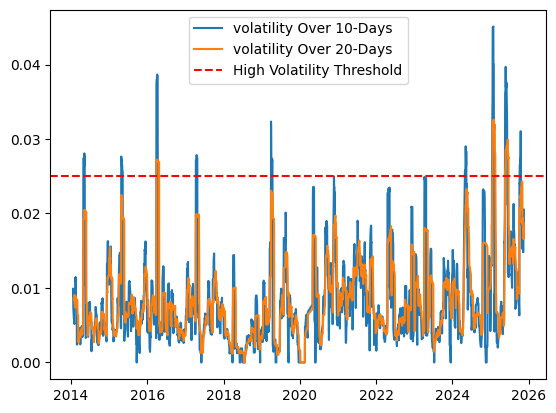

                volatility_10d  volatility_20d
volatility_10d         1.00000         0.76246
volatility_20d         0.76246         1.00000
Variables with Strong Correlation with variable volatility_10d (> 0.25) :  [('200_MA', -0.26876817282042914)]


In [29]:
bop = cp(bop, "volatility")

`For reference comparing BoP with oreedo who is riskier`

In [30]:
from utils import take_stock

In [31]:
ord = take_stock(df, 'oreedo', plot=False)

In [32]:
importlib.reload(utils)
from utils import create_and_plot as cp

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


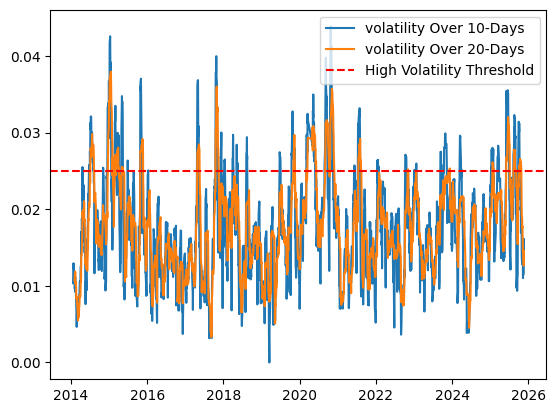

                volatility_10d  volatility_20d
volatility_10d        1.000000        0.807378
volatility_20d        0.807378        1.000000


In [33]:
ord = cp(ord, "returns", plot=False, corr=False)
ord = cp(ord, "volatility", corr=False)

### 1.2.7 `RSI`

In [34]:
import utils
importlib.reload(utils)
from utils import create_and_plot as cp

RSI for 7- days created.
RSI for 14- days created.


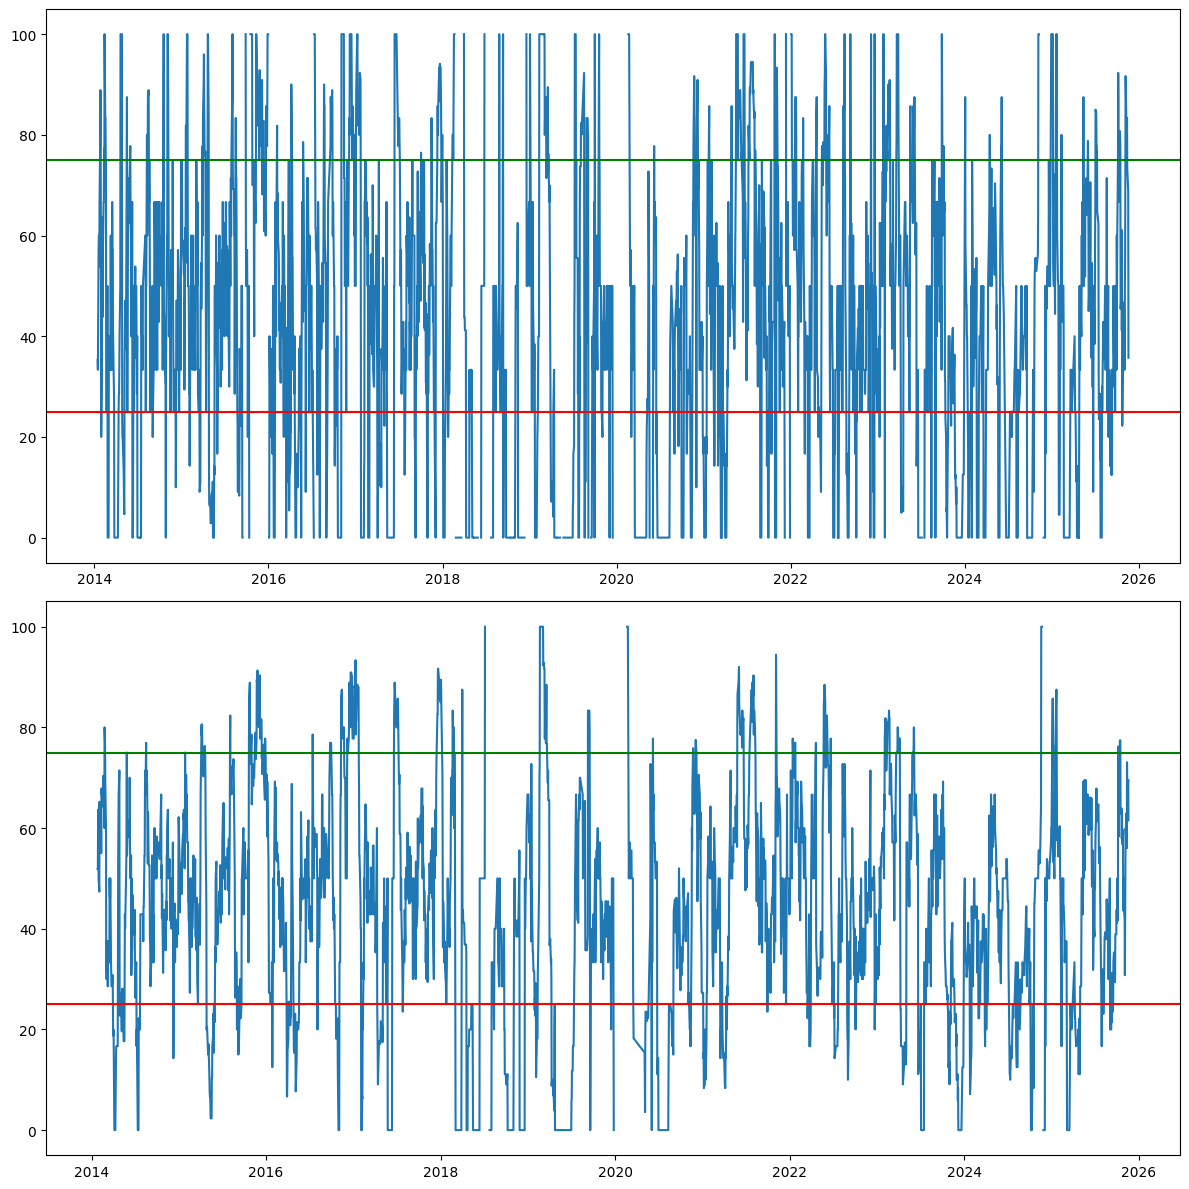

           rsi_7    rsi_14
rsi_7   1.000000  0.721209
rsi_14  0.721209  1.000000
Variables with Strong Correlation with variable rsi_7 (> 0.25) :  [('ma_ratio', 0.2885509696199181), ('r1', 0.2950910720842484), ('r3', 0.46581939398521083), ('r5', 0.5799303987555876)]


In [35]:
bop = cp(bop, "rsi", plot=True)

### 1.2.8 `Liquidity features`

In [36]:
importlib.reload(utils)
from utils import create_and_plot as cp

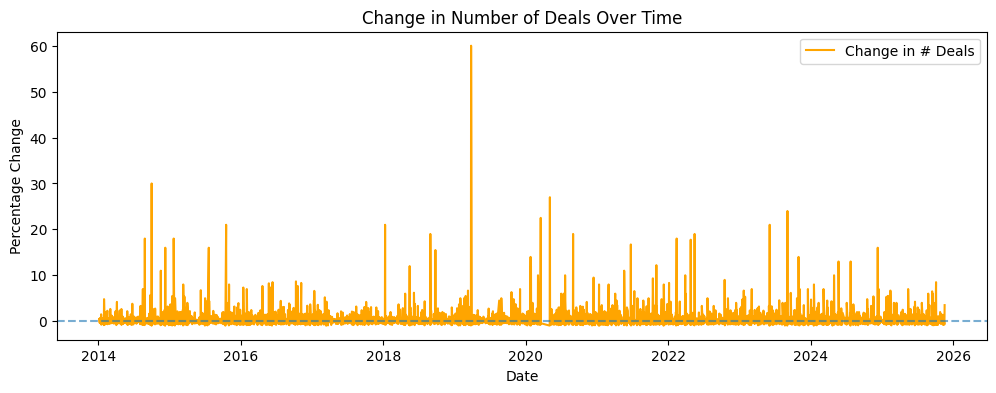

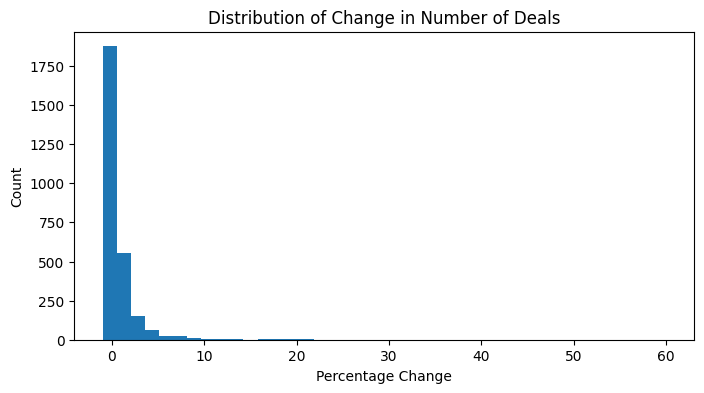

In [37]:
bop = cp(bop, "liquidity")

---------------------------------------

In [38]:
importlib.reload(utils)
from utils import normalize_range, add_temporal_features
from utils import create_and_plot as cp

In [39]:
bop = normalize_range(bop)

Normalized Range Created
               range  range_norm
range       1.000000    0.945146
range_norm  0.945146    1.000000
Due to almost perfect correlation range feature dropped.


### 1.2.9 `Temporal Features`

In [40]:
bop = add_temporal_features(bop)

Temporal Features Created.


### 1.2.10 `MACD`

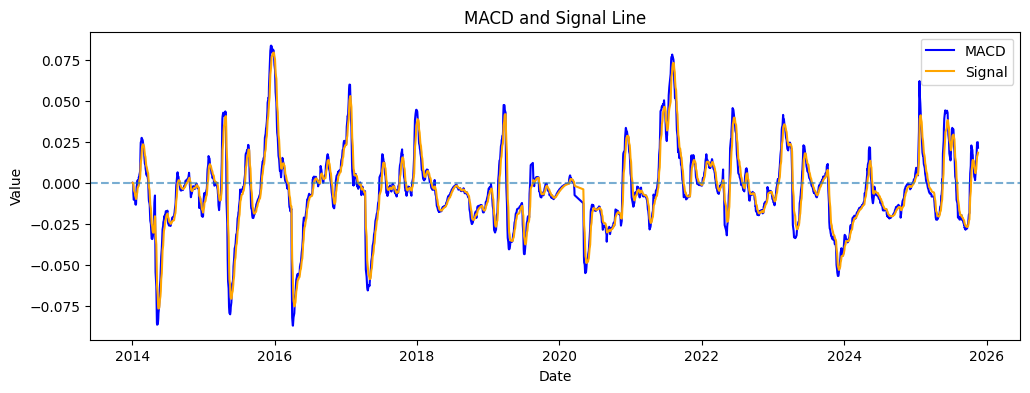

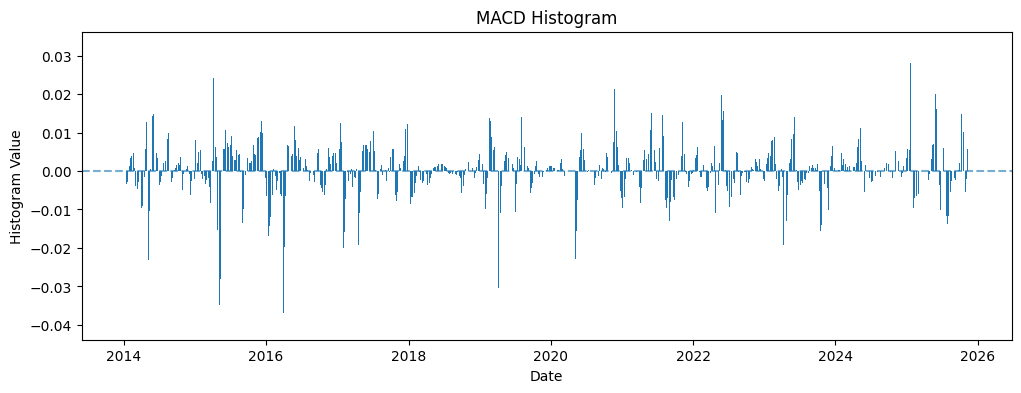

In [41]:
bop = cp(bop, "macd")

### 1.2.11 `Stochastic`

In [42]:
importlib.reload(utils)
from utils import create_and_plot as cp

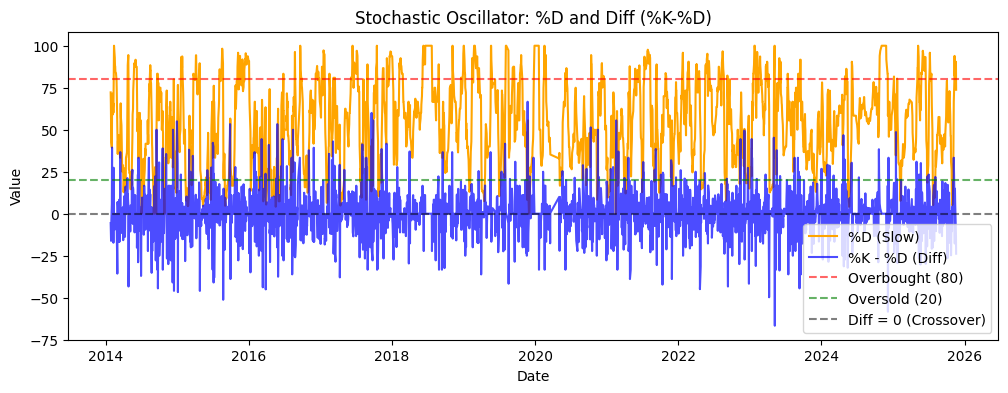

In [43]:
bop = cp(bop, "stochastic")

In [44]:
importlib.reload(visualize)
from visualize import plot_feature_distributions

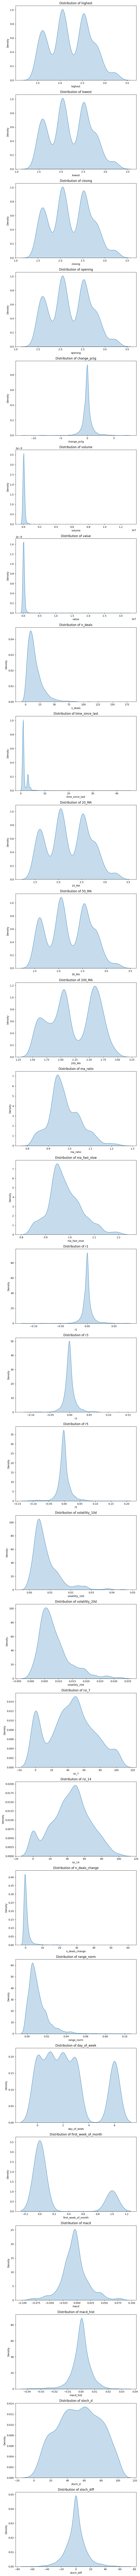

In [45]:
plot_feature_distributions(bop, target_col=None)

### 1.3.0 `After training the model we found out that there is a leakge in the data where change pctg was calculated based on tomorrow's price isntead of today's`

In [46]:
from create_features import fix_stock_change_pctg_leakge
bop = fix_stock_change_pctg_leakge(bop, 'BoP')

## 1.3 `Dropping redundant/highly multi cllinearity features`

In [47]:
corr = bop.corr()
pairs = [
    (i, j, corr.loc[i, j])
    for idx, i in enumerate(corr.columns)
    for j in corr.columns[idx + 1:]
    if abs(corr.loc[i, j]) > 0.85
]
    

In [48]:
pairs

[('highest', 'lowest', np.float64(0.9990559922811156)),
 ('highest', 'closing', np.float64(0.9988500484542382)),
 ('highest', 'opening', np.float64(0.9997520280729839)),
 ('highest', '20_MA', np.float64(0.9919766078418625)),
 ('highest', '50_MA', np.float64(0.9793744803939513)),
 ('highest', '200_MA', np.float64(0.9273834950417738)),
 ('lowest', 'closing', np.float64(0.9985989395491028)),
 ('lowest', 'opening', np.float64(0.9991087628581339)),
 ('lowest', '20_MA', np.float64(0.9919458534782256)),
 ('lowest', '50_MA', np.float64(0.9793493896052592)),
 ('lowest', '200_MA', np.float64(0.9278910596394996)),
 ('closing', 'opening', np.float64(0.9988029294547078)),
 ('closing', '20_MA', np.float64(0.9932748866097996)),
 ('closing', '50_MA', np.float64(0.980956466979782)),
 ('closing', '200_MA', np.float64(0.9289191072706876)),
 ('opening', '20_MA', np.float64(0.9921722429716583)),
 ('opening', '50_MA', np.float64(0.9797622292730859)),
 ('opening', '200_MA', np.float64(0.9279692542905585)),
 

In [49]:
bop.drop(columns=['opening', 'highest', 'lowest', '20_MA', '50_MA', '200_MA', 'volume', 'value'], inplace=True)

## 1.4 `Check for  noisy, missy (either logical or physical), inconsistent, and duplicated Data.`

In [50]:
bop.duplicated().sum()

np.int64(0)

In [51]:
bop.isna().sum()

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64

In [52]:
bop[199:].isna().sum()

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          0
ma_ratio                 0
ma_fast_slow             0
r1                       0
r3                       0
r5                       0
volatility_10d           0
volatility_20d           0
rsi_7                  152
rsi_14                  51
n_deals_change           0
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                  0
stoch_diff               0
change_pctg              0
dtype: int64

In [53]:
bop.describe()

closing      n_deals  clf_target_1d  time_since_last     ma_ratio  \
count  2731.000000  2731.000000    2731.000000      2730.000000  2532.000000   
mean      2.226979    16.203955       0.239839         1.589011     0.978076   
std       0.453706    14.087994       0.427063         1.388704     0.074992   
min       1.400000     1.000000       0.000000         1.000000     0.817082   
25%       1.950000     7.000000       0.000000         1.000000     0.932092   
50%       2.150000    13.000000       0.000000         1.000000     0.964635   
75%       2.550000    21.000000       0.000000         2.000000     1.026728   
max       3.300000   173.000000       1.000000        45.000000     1.244914   

       ma_fast_slow           r1           r3           r5  volatility_10d  \
count   2532.000000  2730.000000  2728.000000  2726.000000     2721.000000   
mean       0.979727    -0.000199    -0.000582    -0.000966        0.008006   
std        0.067853     0.010263     0.016807     0.021443        0.006523   
min        0.841376    -0.117241    -0.114187    -0.125000        0.000000   
25%        0.937559    -0.003953    -0.006061    -0.008032        0.003931   
50%        0.968803     0.000000     0.000000     0.000000        0.006089   
75%        1.019913     0.000000     0.004032     0.004950        0.010112   
max        1.208514     0.075000     0.146667     0.200000        0.045107   

       ...       rsi_14  n_deals_change   range_norm  day_of_week  \
count  ...  2666.000000     2730.000000  2731.000000  2731.000000   
mean   ...    43.569757        0.655203     0.010975     2.376053   
std    ...    22.432148        2.578209     0.010074     2.055885   
min    ...     0.000000       -0.987500     0.000000     0.000000   
25%    ...    28.720238       -0.437500     0.004348     1.000000   
50%    ...    45.000000        0.000000     0.008065     2.000000   
75%    ...    58.333333        0.833333     0.014706     3.000000   
max    ...   100.000000       60.000000     0.100000     6.000000   

       first_week_of_month         macd    macd_hist      stoch_d  \
count          2731.000000  2731.000000  2731.000000  2716.000000   
mean              0.226657    -0.004131     0.000027    53.800206   
std               0.418745     0.023988     0.006959    24.792938   
min               0.000000    -0.087326    -0.040208     0.000000   
25%               0.000000    -0.016819    -0.002816    34.722222   
50%               0.000000    -0.004336     0.000381    54.516317   
75%               0.000000     0.006060     0.003472    73.611111   
max               1.000000     0.083739     0.032554   100.000000   

        stoch_diff  change_pctg  
count  2716.000000  2730.000000  
mean     -0.005698    -0.019860  
std      13.424747     1.026326  
min     -66.666667   -11.724138  
25%      -6.666667    -0.395257  
50%       0.000000     0.000000  
75%       6.060606     0.000000  
max      66.666667     7.500000  

[8 rows x 22 columns]

`All of these makes total sense  except for volume_z which is a huge number for a z_score`

`The entire preprocess, feature engineering and dropping initial workflow will look like this`

`1.Datize date`

`2.Set date as index`

`3.numerize volume`

`4.Create all the default features`

`5.Drop unnecessary features`

-----------------------------------------------------------------------

# `2.Pipeline Creation`

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.inspection import permutation_importance
import joblib

In [55]:
importlib.reload(preprocess)
from preprocess import remove_nas, time_series_split, preprocessor

In [56]:
df = remove_nas(bop)

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64
Remaining Nulls 0


In [57]:
X_train, X_test, y_train, y_test, feature_cols, target_col = time_series_split(df)

In [58]:
preprocess = preprocessor(df, feature_cols, target_col)

# 3. `Model Training`

## 3.1 `Logistic Regression`

In [59]:
lr_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None))
])


In [60]:
import model
importlib.reload(model)
from model import print_validation_scores

In [61]:
print_validation_scores(lr_clf, X_train, y_train)


============ Metrics means:
[{'precision': np.float64(0.47374396330638013)}, {'recall': np.float64(0.509561962055556)}, {'f1': np.float64(0.4644241957996337)}, {'pr_auc': np.float64(0.5122495719517228)}, {'accuracy': np.float64(0.7483679525222551)}]
============ Metrics STDs:
[{'precision': np.float64(0.1136297019322082)}, {'recall': np.float64(0.12790700402152386)}, {'f1': np.float64(0.05847810965317582)}, {'pr_auc': np.float64(0.07389333347076939)}, {'accuracy': np.float64(0.04723230326663868)}]


In [62]:
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['closing', 'r3', 'rsi_7',
                                                   'rsi_14', 'macd', 'stoch_d',
                                                   'stoch_diff']),
                                                 ('median',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_deals', 'time_since_last',
                                                   'ma_ratio', 'ma_fa...
                                                   'range_norm', 'macd_hist',
                                                   'change_pctg']),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['first_week_of_month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day_of_week'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [63]:
test_proba = lr_clf.predict_proba(X_test)[:, 1]


In [64]:
importlib.reload(model)
from model import print_test_score


=== Test Metrics === at threshold 0.7
Accuracy: 0.7905
Precision: 0.5287
Recall: 0.4144
F1: 0.4646
ROC-AUC: 0.7345
PR-AUC: 0.4804
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


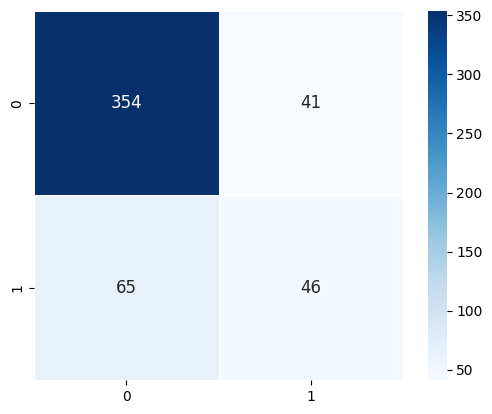

In [65]:
print_test_score(test_proba, y_test)

`Calibrate the model for better interpretability and making more informative relaible decisions according to the respectful threshold`

In [66]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [67]:
importlib.reload(model)
from model import calibrate_and_plot

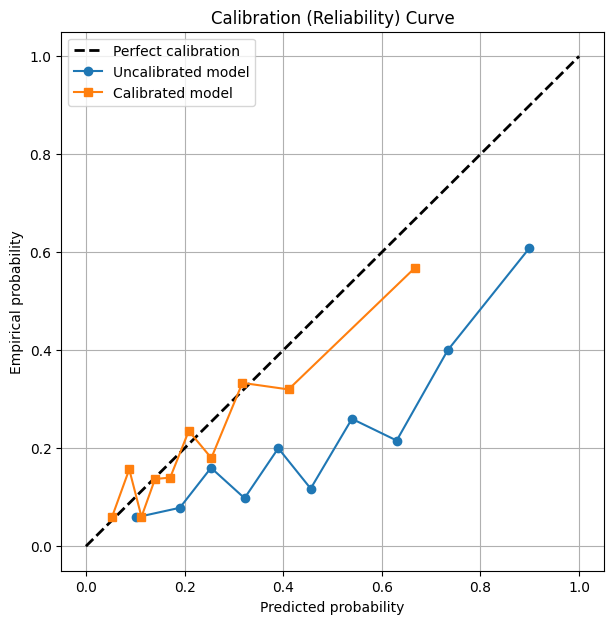

In [68]:
clr_lr, proba_uncal, proba_cal, calib_data = calibrate_and_plot(lr_clf, X_train, y_train, X_test, y_test)


=== Test Metrics === at threshold 0.7
Accuracy: 0.7945
Precision: 0.7059
Recall: 0.1081
F1: 0.1875
ROC-AUC: 0.7174
PR-AUC: 0.4526
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


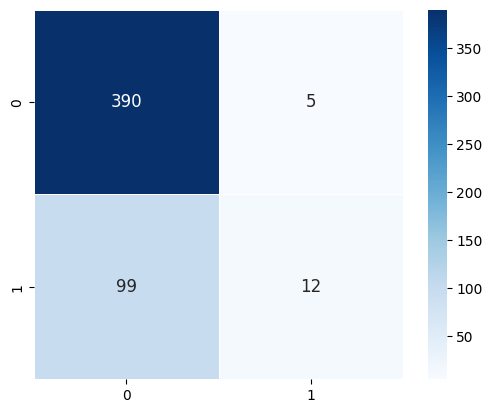

In [69]:
print_test_score(proba_cal, y_test, 0.7)

## 3.2 `Linear SVC`

In [70]:
from sklearn.svm import LinearSVC

svc_linear_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=10_000
    ))
])


## 3.2 `Linear SVC`

In [71]:
from sklearn.svm import SVC

svc_rbf_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        class_weight='balanced',
        probability=True,
        random_state=42
    ))
])


## 3.2 `Linear SVC`

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])


## 3.2 `Linear SVC`

In [ ]:
from xgboost import XGBClassifier


xgb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=2000,        
        learning_rate=0.02,
        max_depth=2,              
        min_child_weight=10,      
        subsample=0.6,
        colsample_bytree=0.6,
        reg_lambda=5.0,           
        reg_alpha=1.0,            
        gamma=1.0,               
        random_state=42,
        n_jobs=-1
    ))
])



`Compare`

In [82]:
base_models = {
    "logistic": lr_clf,
    "svc_rbf": svc_rbf_clf,
    "random_forest": rf_clf,
    "xgboost": xgb_clf
}


In [83]:
import numpy as np

def get_scores(model, X):
    """
    Returns continuous scores for ranking metrics.
    Uses decision_function if available, else predict_proba.
    """
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model has neither decision_function nor predict_proba")


In [84]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.base import clone
import pandas as pd

def compare_models_time_series(
    models,
    X,
    y,
    n_splits=5
):
    """
    Compare base models using TimeSeriesSplit.
    Metrics:
      - PR-AUC (primary)
      - ROC-AUC (secondary)

    Returns a sorted DataFrame.
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    for name, model in models.items():
        pr_aucs = []
        roc_aucs = []

        for tr_idx, va_idx in tscv.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            m = clone(model)
            m.fit(X_tr, y_tr)

            scores = m.predict_proba(X_va)[:, 1]

            pr_aucs.append(average_precision_score(y_va, scores))
            roc_aucs.append(roc_auc_score(y_va, scores))

        results.append({
            "model": name,
            "pr_auc_mean": np.mean(pr_aucs),
            "pr_auc_std": np.std(pr_aucs),
            "roc_auc_mean": np.mean(roc_aucs),
            "roc_auc_std": np.std(roc_aucs)
        })

    return (
        pd.DataFrame(results)
        .sort_values("pr_auc_mean", ascending=False)
        .reset_index(drop=True)
    )


In [85]:
results_df = compare_models_time_series(
    models=base_models,
    X=X_train,
    y=y_train,
    n_splits=5
)

print(results_df)


           model  pr_auc_mean  pr_auc_std  roc_auc_mean  roc_auc_std
0       logistic     0.512250    0.073893      0.746574     0.037079
1        xgboost     0.483350    0.110327      0.712936     0.047744
2  random_forest     0.475335    0.117881      0.701882     0.068134
3        svc_rbf     0.470383    0.096968      0.719345     0.031178


In [86]:
print_validation_scores(xgb_clf, X_train, y_train)

============ Metrics means:
[{'precision': np.float64(0.5353877701246123)}, {'recall': np.float64(0.2938209023846698)}, {'f1': np.float64(0.35417937563003243)}, {'pr_auc': np.float64(0.4833500755483291)}, {'accuracy': np.float64(0.7655786350148367)}]
============ Metrics STDs:
[{'precision': np.float64(0.1913261736576726)}, {'recall': np.float64(0.06713836911001991)}, {'f1': np.float64(0.045605903346377055)}, {'pr_auc': np.float64(0.11032681244212095)}, {'accuracy': np.float64(0.04519746650364339)}]


In [87]:
print_validation_scores(lr_clf, X_train, y_train)

============ Metrics means:
[{'precision': np.float64(0.47374396330638013)}, {'recall': np.float64(0.509561962055556)}, {'f1': np.float64(0.4644241957996337)}, {'pr_auc': np.float64(0.5122495719517228)}, {'accuracy': np.float64(0.7483679525222551)}]
============ Metrics STDs:
[{'precision': np.float64(0.1136297019322082)}, {'recall': np.float64(0.12790700402152386)}, {'f1': np.float64(0.05847810965317582)}, {'pr_auc': np.float64(0.07389333347076939)}, {'accuracy': np.float64(0.04723230326663868)}]


In [88]:
print_validation_scores(rf_clf, X_train, y_train)


============ Metrics means:
[{'precision': np.float64(0.7185783298826778)}, {'recall': np.float64(0.13798651585950716)}, {'f1': np.float64(0.21413205389521792)}, {'pr_auc': np.float64(0.47533548317377783)}, {'accuracy': np.float64(0.7780415430267064)}]
============ Metrics STDs:
[{'precision': np.float64(0.2675870691702807)}, {'recall': np.float64(0.05327982815579969)}, {'f1': np.float64(0.07158295502442033)}, {'pr_auc': np.float64(0.11788128938247304)}, {'accuracy': np.float64(0.06059228020463014)}]


In [89]:
xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['closing', 'r3', 'rsi_7',
                                                   'rsi_14', 'macd', 'stoch_d',
                                                   'stoch_diff']),
                                                 ('median',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_deals', 'time_since_last',
                                                   'ma_ratio', 'ma_fa...
                               feature_types=None, feature_weights=None,
                               gamma=1.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=2000, n_jobs=-1,
                               num_parallel_tree=None, ...))])


=== Test Metrics === at threshold 0.65
Accuracy: 0.8202
Precision: 0.7941
Recall: 0.2432
F1: 0.3724
ROC-AUC: 0.7505
PR-AUC: 0.4929
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


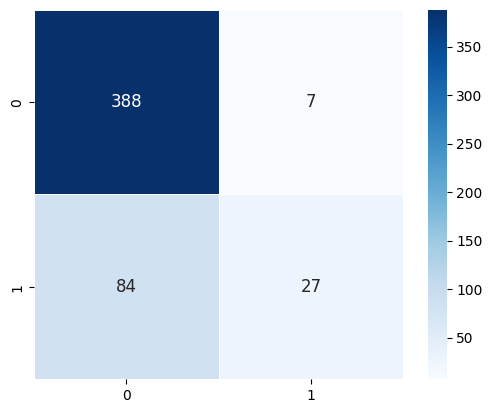

In [90]:
xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]
print_test_score(xgb_proba, y_test, 0.65)


=== Test Metrics === at threshold 0.45
Accuracy: 0.7925
Precision: 0.5789
Recall: 0.1982
F1: 0.2953
ROC-AUC: 0.7529
PR-AUC: 0.4871
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


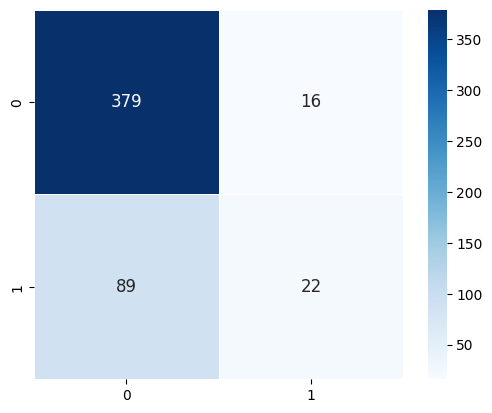

In [91]:
rf_clf.fit(X_train, y_train)
rf_proba = rf_clf.predict_proba(X_test)[:, 1]
print_test_score(rf_proba, y_test, 0.45)


=== Test Metrics === at threshold 0.85
Accuracy: 0.7964
Precision: 0.6111
Recall: 0.1982
F1: 0.2993
ROC-AUC: 0.7345
PR-AUC: 0.4804
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


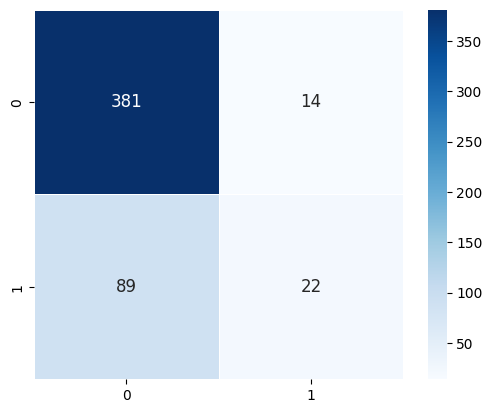

In [92]:
lr_clf.fit(X_train, y_train)
log_proba = lr_clf.predict_proba(X_test)[:, 1]
print_test_score(log_proba, y_test, 0.85)


=== Test Metrics === at threshold 0.6
Accuracy: 0.7984
Precision: 0.7368
Recall: 0.1261
F1: 0.2154
ROC-AUC: 0.7544
PR-AUC: 0.4865
Confusion Matrix:
 Axes(0.1675,0.11;0.5775x0.77)


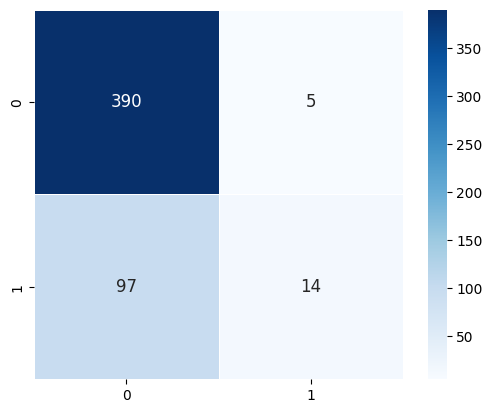

In [95]:
svc_rbf_clf.fit(X_train, y_train)
svc_proba = svc_rbf_clf.predict_proba(X_test)[:, 1]
print_test_score(svc_proba, y_test, 0.6)

`Choose XGB and Logistic`

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

lr_param_grid = {
    "clf__C": np.logspace(-4, 2, 12),  
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"],
    "clf__class_weight": [None, "balanced"]
}

lr_search = GridSearchCV(
    lr_clf,
    param_grid=lr_param_grid,
    scoring="average_precision",
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1
)

lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_param_dist = {
    "clf__max_depth": randint(2, 6),           
    "clf__learning_rate": uniform(0.01, 0.09),
    "clf__n_estimators": randint(300, 1200),
    "clf__subsample": uniform(0.5, 0.5),
    "clf__colsample_bytree": uniform(0.5, 0.5),
    "clf__min_child_weight": randint(5, 30),
    "clf__reg_lambda": uniform(1.0, 9.0),
    "clf__reg_alpha": uniform(0.0, 2.0),
    "clf__gamma": uniform(0.0, 2.0),
}

xgb_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=80,                    
    scoring="average_precision",
    cv=TimeSeriesSplit(n_splits=5),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [126]:
from sklearn.calibration import CalibratedClassifierCV

cal_lr = CalibratedClassifierCV(
    estimator=best_lr,
    method="sigmoid",
    cv=TimeSeriesSplit(n_splits=5)
)

cal_xgb = CalibratedClassifierCV(
    estimator=best_xgb,
    method="sigmoid",
    cv=TimeSeriesSplit(n_splits=5)
)

cal_lr.fit(X_train, y_train)
cal_xgb.fit(X_train, y_train)


CalibratedClassifierCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('mean',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer()),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['closing',
                                                                                    'r3',
                                                                                    'rsi_7',
                                                                                    'rsi_14',
                                                                                    'macd',
                                                                                    'stoch_d',
                                                                                    'stoch_diff']),
                                                                                  ('median',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    Simpl...
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=np.float64(0.057668552052040585),
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=5,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=603,
                                                                n_jobs=-1,
                                                                num_parallel_tree=None, ...))]))

In [127]:
from sklearn.metrics import precision_recall_curve

In [128]:
def pick_threshold_precision_constraint(y_true, proba_pos, min_precision=0.80):
    prec, rec, thr = precision_recall_curve(y_true, proba_pos)
    prec, rec = prec[:-1], rec[:-1]

    ok = prec >= min_precision
    if not np.any(ok):
        idx = np.argmax(prec)
        return thr[idx], prec[idx], rec[idx]

    idx = np.argmax(rec[ok])
    return thr[ok][idx], prec[ok][idx], rec[ok][idx]

In [147]:
p_lr_val = cal_lr.predict_proba(X_train)[:, 1]
p_xgb_val = cal_xgb.predict_proba(X_train)[:, 1]

min_pre = 0.9
lr_thr, lr_prec, lr_rec = pick_threshold_precision_constraint(
    y_train, p_lr_val, min_precision=min_pre
)

xgb_thr, xgb_prec, xgb_rec = pick_threshold_precision_constraint(
    y_train, p_xgb_val, min_precision=min_pre
)


In [148]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)

def final_eval(model, threshold, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }


In [149]:
lr_results = final_eval(cal_lr, lr_thr, X_test, y_test)


In [150]:
xgb_results = final_eval(cal_xgb, xgb_thr, X_test, y_test)


In [151]:
lr_results

{'accuracy': 0.7944664031620553,
 'precision': 0.7058823529411765,
 'recall': 0.10810810810810811,
 'f1': 0.1875,
 'roc_auc': 0.7212909111643289,
 'pr_auc': 0.45073544633450346,
 'confusion_matrix': array([[390,   5],
        [ 99,  12]])}

In [152]:
xgb_results

{'accuracy': 0.8023715415019763,
 'precision': 0.7037037037037037,
 'recall': 0.17117117117117117,
 'f1': 0.2753623188405797,
 'roc_auc': 0.7295016535522864,
 'pr_auc': 0.47333421548676996,
 'confusion_matrix': array([[387,   8],
        [ 92,  19]])}

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def tune_threshold_min_precision(y_true, proba_pos, min_precision=0.80):
    """
    Returns:
        best_threshold
        achieved_precision
        achieved_recall
    """
    precision, recall, thresholds = precision_recall_curve(y_true, proba_pos)

    
    precision = precision[:-1]
    recall = recall[:-1]

    valid = precision >= min_precision

    if not np.any(valid):
        
        best_idx = np.argmax(precision)
        return thresholds[best_idx], precision[best_idx], recall[best_idx]

    best_idx = np.argmax(recall[valid])
    valid_thresholds = thresholds[valid]

    return (
        valid_thresholds[best_idx],
        precision[valid][best_idx],
        recall[valid][best_idx],
    )

In [161]:
p_lr_train = best_lr.predict_proba(X_train)[:, 1]

lr_thr, lr_prec, lr_rec = tune_threshold_min_precision(
    y_train,
    p_lr_train,
    min_precision=0.90
)

print("Logistic threshold:")
print("  threshold =", lr_thr)
print("  precision =", lr_prec)
print("  recall    =", lr_rec)

Logistic threshold:
  threshold = 0.7525425927765614
  precision = 0.9130434782608695
  recall    = 0.08519269776876268


In [162]:
p_xgb_train = best_xgb.predict_proba(X_train)[:, 1]

xgb_thr, xgb_prec, xgb_rec = tune_threshold_min_precision(
    y_train,
    p_xgb_train,
    min_precision=0.90
)

print("XGBoost threshold:")
print("  threshold =", xgb_thr)
print("  precision =", xgb_prec)
print("  recall    =", xgb_rec)


XGBoost threshold:
  threshold = 0.5396126
  precision = 0.9007936507936508
  recall    = 0.460446247464503


In [163]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

def evaluate_at_threshold(model, threshold, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
    }


In [164]:
lr_test_results = evaluate_at_threshold(
    best_lr, lr_thr, X_test, y_test
)

xgb_test_results = evaluate_at_threshold(
    best_xgb, xgb_thr, X_test, y_test
)

print("LR test results:", lr_test_results)



LR test results: {'accuracy': 0.7905138339920948, 'precision': 0.631578947368421, 'recall': 0.10810810810810811, 'f1': 0.18461538461538463, 'confusion_matrix': array([[388,   7],
       [ 99,  12]])}


In [165]:
print("XGB test results:", xgb_test_results)

XGB test results: {'accuracy': 0.808300395256917, 'precision': 0.6666666666666666, 'recall': 0.25225225225225223, 'f1': 0.3660130718954248, 'confusion_matrix': array([[381,  14],
       [ 83,  28]])}
